In [81]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

from lib import (
    FinnDir,
    load_exp_data,
    load_exp_conf,
    compute_core2B_profile,
    finn_fit_retardation,
)

In [30]:
finn_out_path = Path("../data_out/finn/")

# Core 2

## Training

In [31]:
data_core2_df = load_exp_data(name="Core 2")
conf_core2 = load_exp_conf(name="Core 2")

data_core2b_df = load_exp_data(name="Core 2B")
conf_core2b = load_exp_conf(name="Core 2B")

In [32]:
finn_core2_dir = FinnDir(finn_out_path / "core2")
# is_ok_to_delete = input(f"Remove {finn_core2_dir.path} (y/n)? ")
# if is_ok_to_delete == "y":
# shutil.rmtree(finn_core2_dir.path.absolute())
# finn_core2_dir = FinnDir(finn_root / "core2")
np.save(finn_core2_dir.c_train_path, data_core2_df["c_diss"])
np.save(finn_core2_dir.t_train_path, data_core2_df["time"])
finn_fit_retardation(
    out_dir=finn_core2_dir.path,
    is_exp_data=True,
    n_epochs=21,
    **conf_core2,
)

## Analysis

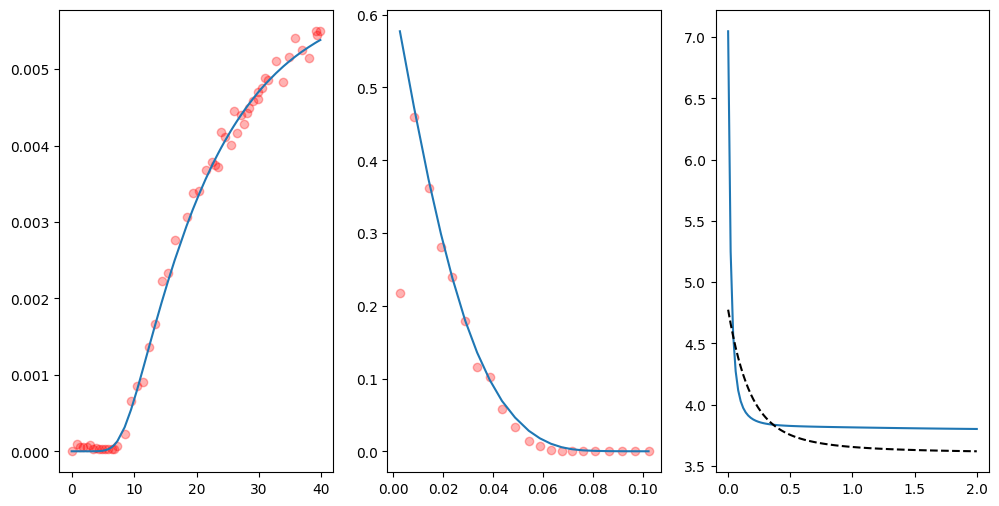

In [33]:
core2b_pred = compute_core2B_profile(finn_core2_dir)

u = np.load(finn_core2_dir.u_ret_path)

n_epochs = finn_core2_dir.n_epochs
fig, axs = plt.subplots(ncols=3, figsize=(12, 6))

axs[0].scatter(data_core2_df["time"], data_core2_df["c_diss"], color="red", alpha=0.3)
axs[0].plot(
    data_core2_df["time"],
    np.load(finn_core2_dir.get_data_pred_path(n_epochs - 1)),
    zorder=10,
)

axs[1].scatter(data_core2b_df["x"], data_core2b_df["c_tot"], color="red", alpha=0.3)
axs[1].plot(data_core2b_df["x"], core2b_pred, zorder=10)

axs[2].plot(*finn_core2_dir.best_ret_points)
axs[2].plot(
    u,
    np.load(
        "/Users/r/Documents/dev/tmp/finn_with_julia/python/diffusion_sorption/experimental_data/learned_retardation.npy"
    ),
    "k--",
)
plt.show()

# FINN Results from P3INN PIs

In [34]:
finn_root = finn_out_path / "p3inn_core2_new_multiprocessing"
finn_dirs = list(map(FinnDir, finn_root.iterdir()))

Skipping FinnDir(path=PosixPath('../data_out/finn/p3inn_core2_new_multiprocessing/down_0.95'))
[Errno 2] No such file or directory: '../data_out/finn/p3inn_core2_new_multiprocessing/up_0.95/finn_loss.txt.npy'


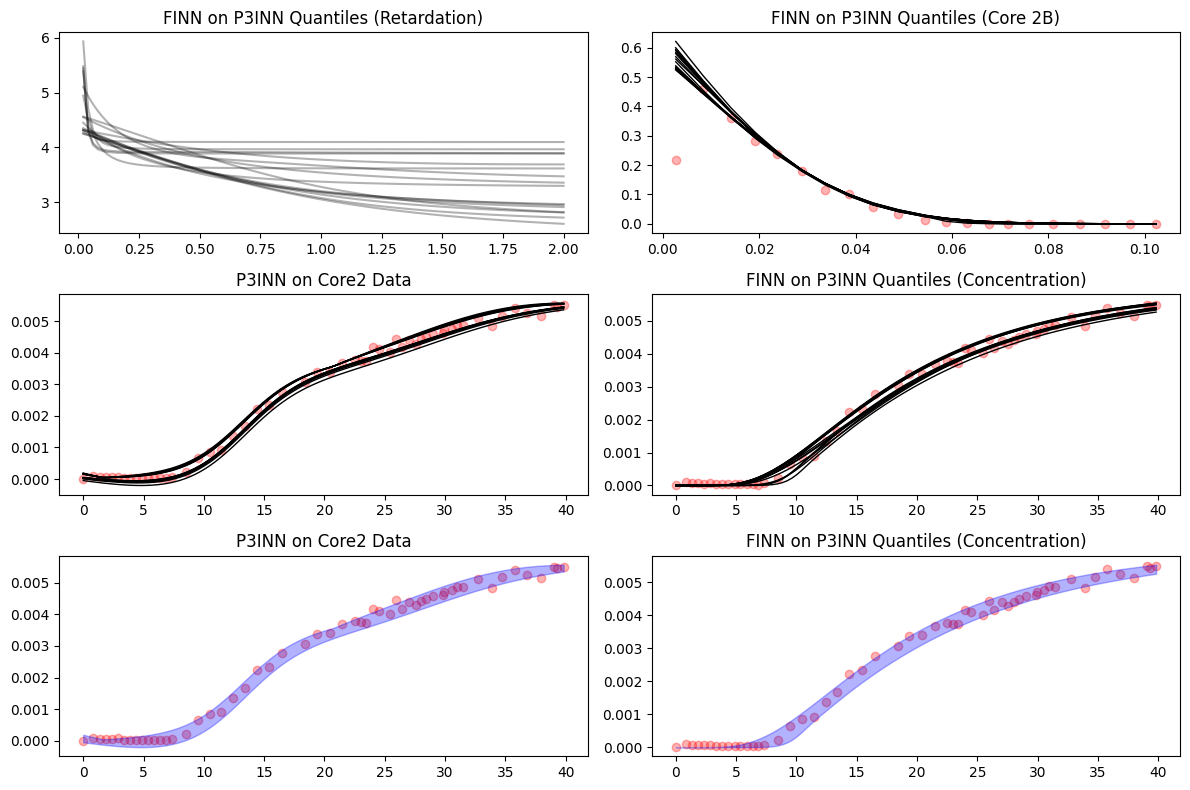

In [35]:
data_core2_df = load_exp_data("Core 2")
data_core2b_df = load_exp_data("Core 2B")

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12, 8))

data_kwargs = {"color": "red", "label": "Core2 Data", "alpha": 0.3, "edgecolor": None}
t_data = data_core2_df["time"]
axs[0, 1].scatter(data_core2b_df["x"], data_core2b_df["c_tot"], **data_kwargs)
axs[1, 0].scatter(data_core2_df["time"], data_core2_df["c_diss"], **data_kwargs)
axs[1, 1].scatter(data_core2_df["time"], data_core2_df["c_diss"], **data_kwargs)

all_core2_PIs_p3inn = []
all_core2_preds_finn = []
all_core2b_preds_finn = []

for finn_dir in finn_dirs:
    try:
        u_ret = np.load(finn_dir.u_ret_path)
        loss = np.load(finn_dir.loss_path)
        best_epoch = finn_dir.best_epoch
        ret = np.load(finn_dir.get_pred_ret_path(best_epoch))
        pred_data = np.load(finn_dir.get_data_pred_path(best_epoch))
        data = np.load(finn_dir.c_train_path)
    except FileNotFoundError as e:
        print(e)
        continue

    pred_kwargs = {"color": "black", "zorder": 1, "alpha": 1.0, "lw": 1.0}
    if np.any(ret < 1) or np.any(ret > 100):
        print("Skipping", finn_dir)
        pred_kwargs["color"] = "red"
        pred_kwargs["zorder"] = 10
        pred_kwargs["lw"] = 3
        continue

    core2b_c = compute_core2B_profile(finn_dir)

    all_core2_PIs_p3inn.append(data)
    all_core2_preds_finn.append(pred_data)
    all_core2b_preds_finn.append(core2b_c)

    t_eval = np.linspace(t_data.min(), t_data.max(), len(data))

    axs[0, 0].set_title("FINN on P3INN Quantiles (Retardation)")
    axs[0, 0].plot(u_ret[1:], ret[1:], "k-", alpha=0.3)

    axs[0, 1].set_title("FINN on P3INN Quantiles (Core 2B)")
    axs[0, 1].plot(data_core2b_df["x"], core2b_c, "-", **pred_kwargs)

    axs[1, 0].set_title("P3INN on Core2 Data")
    axs[1, 0].plot(t_eval, data, "-", **pred_kwargs)

    axs[1, 1].set_title("FINN on P3INN Quantiles (Concentration)")
    axs[1, 1].plot(t_eval, pred_data, "-", **pred_kwargs)

bound_upper_p3inn = np.max(all_core2_PIs_p3inn, axis=0)
bound_lower_p3inn = np.min(all_core2_PIs_p3inn, axis=0)
bound_upper_finn = np.max(all_core2_preds_finn, axis=0)
bound_lower_finn = np.min(all_core2_preds_finn, axis=0)

pi_kwargs = dict(color="blue", alpha=0.3, zorder=10)
axs[2, 0].set_title("P3INN on Core2 Data")
axs[2, 0].fill_between(t_eval, bound_lower_p3inn, bound_upper_p3inn, **pi_kwargs)
axs[2, 0].scatter(data_core2_df["time"], data_core2_df["c_diss"], **data_kwargs)

axs[2, 1].set_title("FINN on P3INN Quantiles (Concentration)")
axs[2, 1].fill_between(t_eval, bound_lower_finn, bound_upper_finn, **pi_kwargs)
axs[2, 1].scatter(data_core2_df["time"], data_core2_df["c_diss"], **data_kwargs)

plt.tight_layout()
plt.show()

## Reliability Curves (TODO)

## Log-Likelihood

In [152]:
def compute_loglikelihood_core2(mean, upper, lower):
    mean = np.interp(t_data, t_eval, mean)
    upper = np.interp(t_data, t_eval, upper)
    lower = np.interp(t_data, t_eval, lower)

    # mean = (upper + lower) / 2
    # FIXME: Assumes 5% and 95% quantiles are given
    sigmas = (upper - lower) / 3.29
    sigmas[sigmas < 1e-14] = 1e-14
    log_likeli = norm.logpdf(data_core2_df["c_diss"], loc=mean, scale=sigmas)
    return np.median(log_likeli), log_likeli[9:].mean(), log_likeli.mean()

### FINN on P3INN

In [149]:
# mean_core2_preds_finn = (bound_upper_finn + bound_lower_finn) / 2
mean_core2_preds_finn = np.mean(all_core2_preds_finn, axis=0)

sigmas_core2_preds_finn = (bound_upper_finn - bound_lower_finn) / 3.29
sigmas_core2_preds_finn[sigmas_core2_preds_finn < 1e-14] = 1e-14

gauss_upper = mean_core2_preds_finn + 1.645 * sigmas_core2_preds_finn
gauss_lower = mean_core2_preds_finn - 1.645 * sigmas_core2_preds_finn

mean_core2_preds_finn_interp = np.interp(data_core2_df["time"], t_eval, mean_core2_preds_finn)
sigmas_core2_preds_finn = np.interp(
    data_core2_df["time"], t_eval, sigmas_core2_preds_finn
)
loglikeli_finn = norm.logpdf(
    data_core2_df["c_diss"], loc=mean_core2_preds_finn_interp, scale=sigmas_core2_preds_finn
)

### MCMC

MCMC: 7.543378797770382 7.46057045343051 -1917.6650167559012
FINN: 7.644273143477853 7.560276857163886 -13620517359604.05
FINN: 7.644273144721639 7.560276855483706 -13620518130858.047


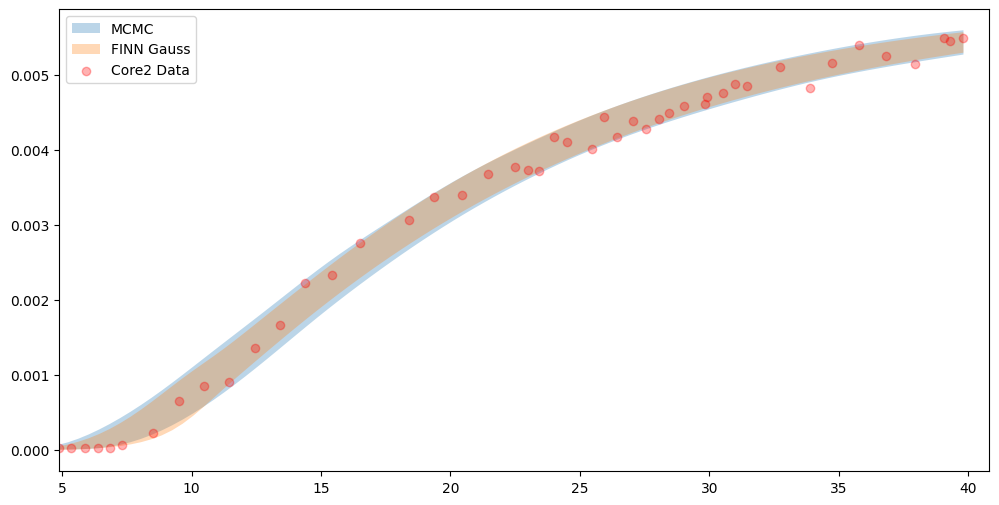

In [153]:
mean_core2_df = (
    pd.read_csv("../data/digitized/mean_core2.csv")
    .sort_values("x")
    .reset_index(drop=True)
)
mean_core2_df["y"] /= 1000
upper_mcmc_PI_core2_df = (
    pd.read_csv("../data/digitized/upper_mcmc_PI_core2.csv")
    .sort_values("x")
    .reset_index(drop=True)
)
upper_mcmc_PI_core2_df["y"] /= 1000
lower_mcmc_PI_core2_df = (
    pd.read_csv("../data/digitized/lower_mcmc_PI_core2.csv")
    .sort_values("x")
    .reset_index(drop=True)
)
lower_mcmc_PI_core2_df["y"] /= 1000

plt.figure(figsize=(12, 6))

from scipy.interpolate import UnivariateSpline

mean_core2_paper = UnivariateSpline(
    mean_core2_df["x"], mean_core2_df["y"], s=0.0
)(t_eval)
upper_mcmc_PI_core2 = UnivariateSpline(
    upper_mcmc_PI_core2_df["x"], upper_mcmc_PI_core2_df["y"], s=0.0
)(t_eval)
lower_mcmc_PI_core2 = UnivariateSpline(
    lower_mcmc_PI_core2_df["x"], lower_mcmc_PI_core2_df["y"], s=0.0
)(t_eval)

# check that spline interpolation works
# plt.plot(lower_mcmc_PI_core2_df["x"], lower_mcmc_PI_core2_df["y"], "b-o")
# plt.plot(upper_mcmc_PI_core2_df["x"], upper_mcmc_PI_core2_df["y"], "b-o")
# plt.plot(mean_core2_df["x"], mean_core2_df["y"], "b-o")
# plt.plot(t_eval, mean_core2_paper)
# plt.plot(t_eval, upper_mcmc_PI_core2)
# plt.plot(t_eval, lower_mcmc_PI_core2)


plt.fill_between(
    t_eval, lower_mcmc_PI_core2, upper_mcmc_PI_core2, alpha=0.3, label="MCMC"
)
plt.fill_between(t_eval, gauss_lower, gauss_upper, alpha=0.3, label="FINN Gauss")
plt.scatter(t_data, data_core2_df["c_diss"], **data_kwargs)
plt.xlim(t_data[9:].min(), t_data.max()*1.025)
plt.legend()

# loglikeli_mcmc = norm.logpdf(
#     data_core2_df["c_diss"], loc=mean_core2_preds_finn, scale=sigmas_core2_preds_finn
# )
print("MCMC:", *compute_loglikelihood_core2(mean_core2_paper, upper_mcmc_PI_core2, lower_mcmc_PI_core2))
print(
    "FINN:", np.median(loglikeli_finn), loglikeli_finn[9:].mean(), loglikeli_finn.mean()
)
print("FINN:", *compute_loglikelihood_core2(mean_core2_preds_finn, bound_upper_finn, bound_lower_finn))

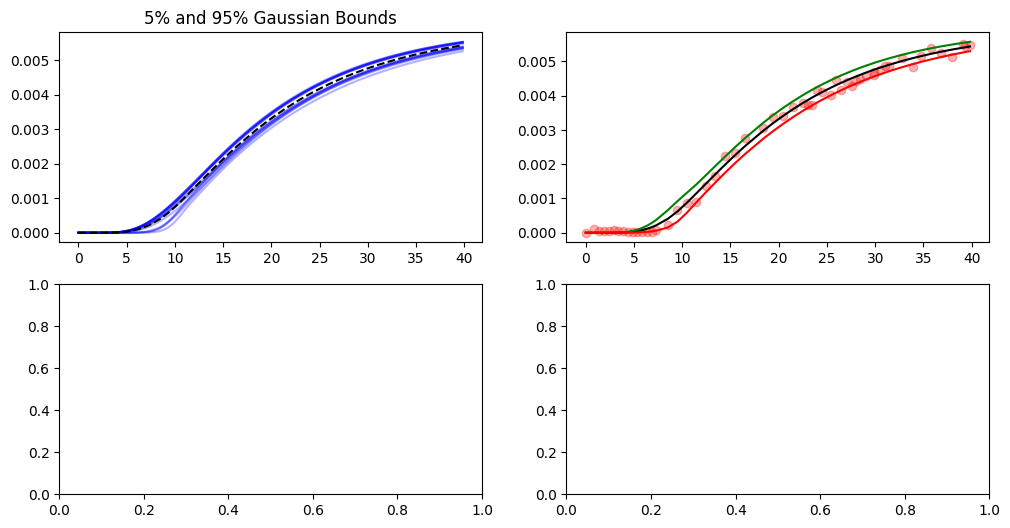

In [80]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 6))
axs[0, 0].set_title("FINN on P3INN Quantiles (Concentration) with Mean")
axs[0, 0].plot(t_eval, np.array(all_core2_preds_finn).T, "b-", alpha=0.3)
axs[0, 0].plot(t_data, mean_core2_preds_finn, "k--")
# axs[0,0].plot(bound_upper_finn, "b-")
# axs[0,0].plot(bound_lower_finn, "b-")
axs[0, 0].set_title("5% and 95% Gaussian Bounds")
axs[0, 1].plot(t_data, mean_core2_preds_finn, "k-")
axs[0, 1].plot(t_eval, gauss_upper, "g-")
axs[0, 1].plot(t_eval, gauss_lower, "r-")
axs[0, 1].scatter(t_data, data_core2_df["c_diss"], color="red", alpha=0.3)
plt.show()

# Appendix

## All FINN predictions for PI3NN PIs separately

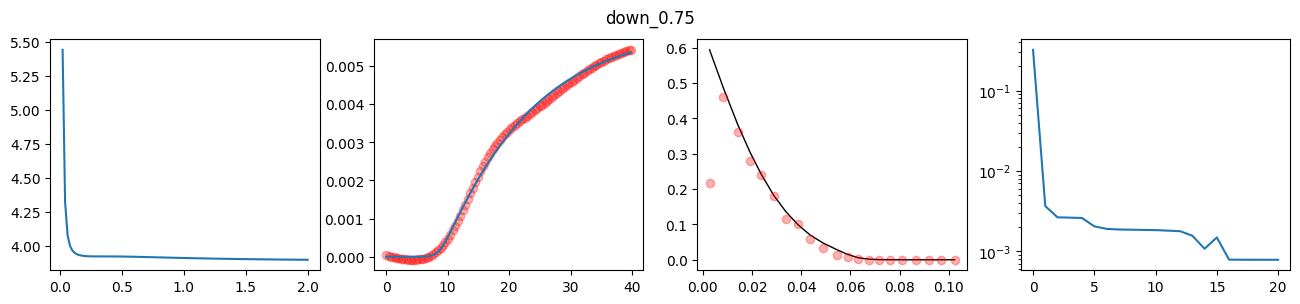

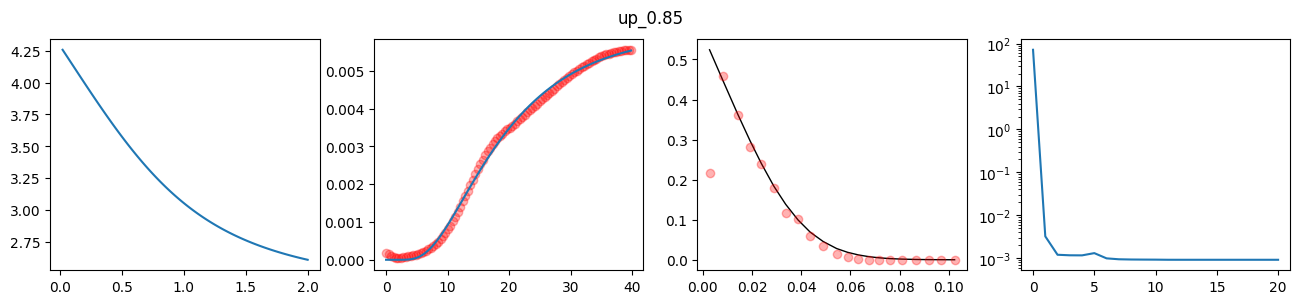

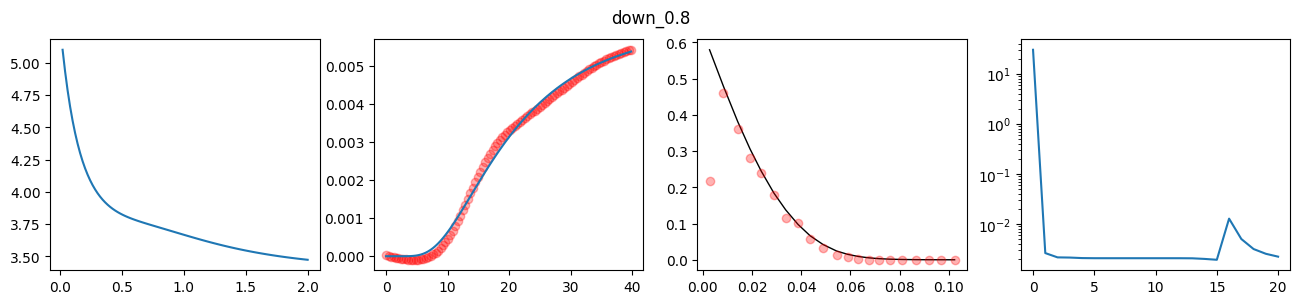

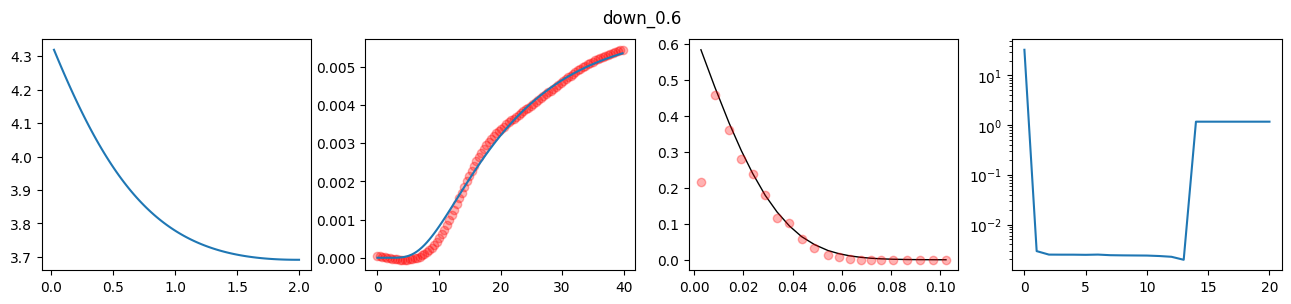

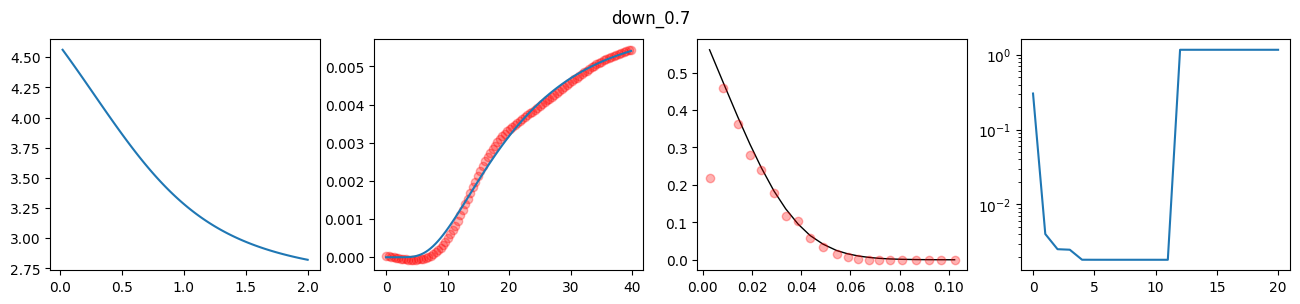

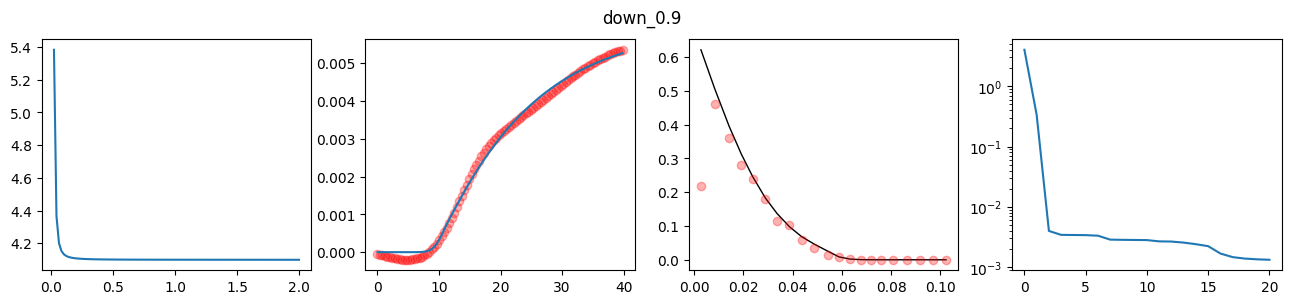

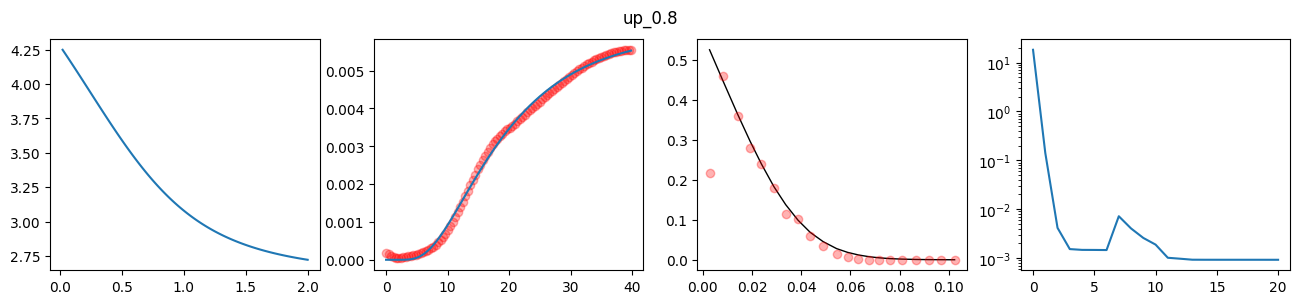

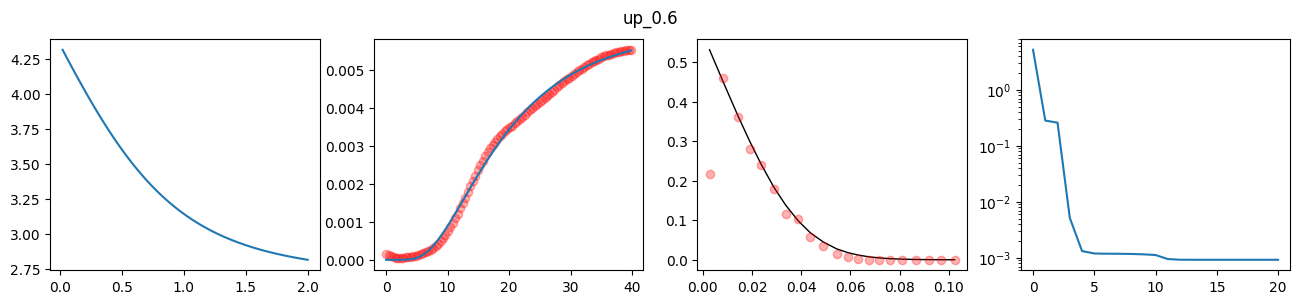

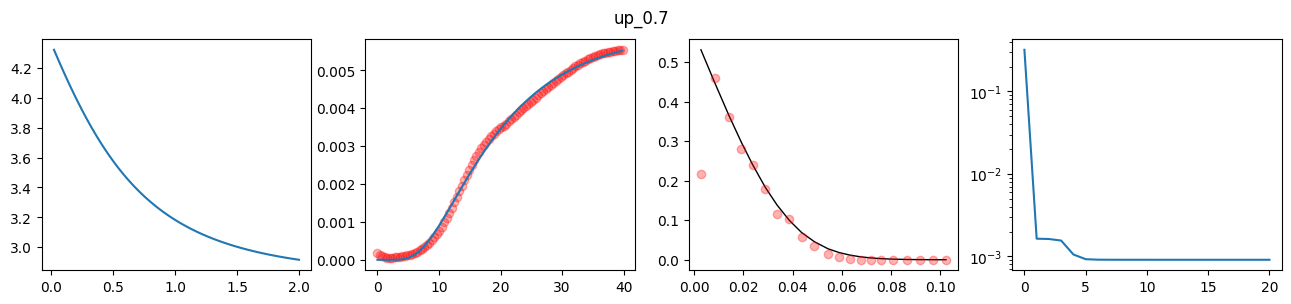

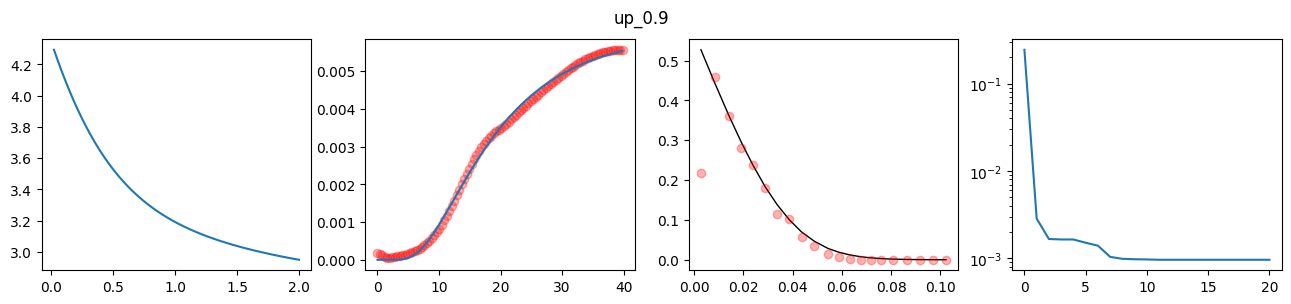

Skipping due to dt = 0 FinnDir(path=PosixPath('../data_out/finn/p3inn_core2_new_multiprocessing/down_0.95'))


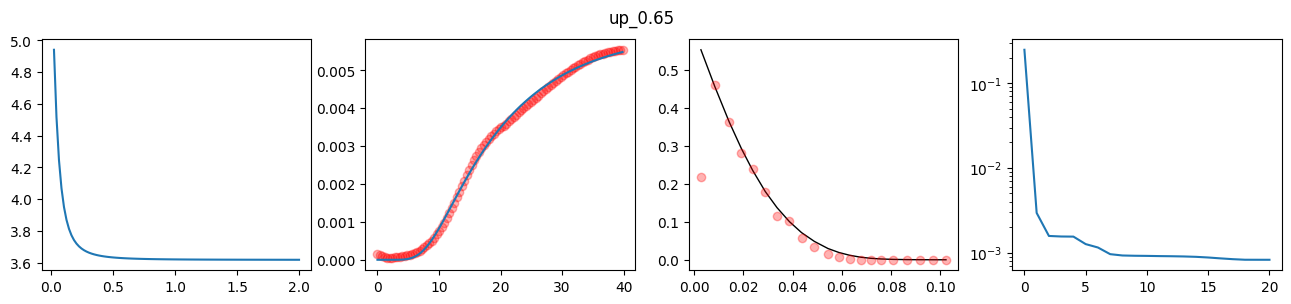

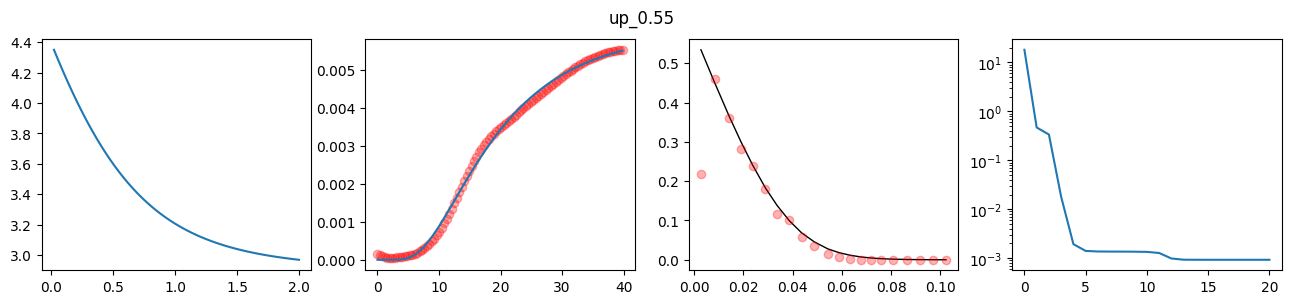

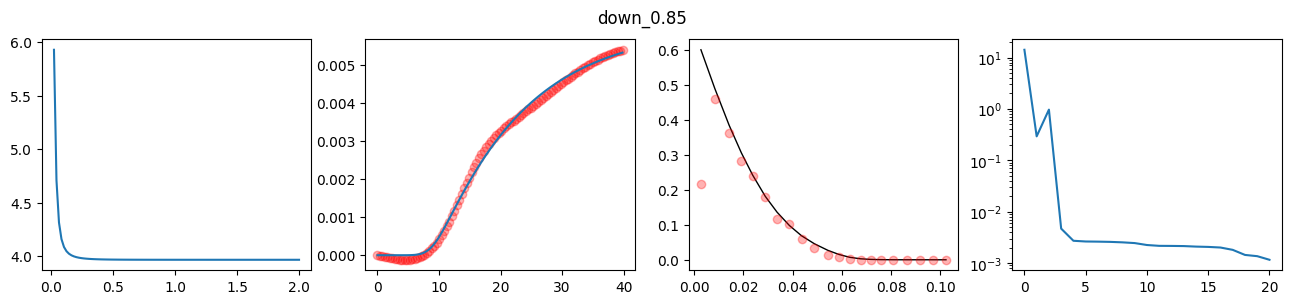

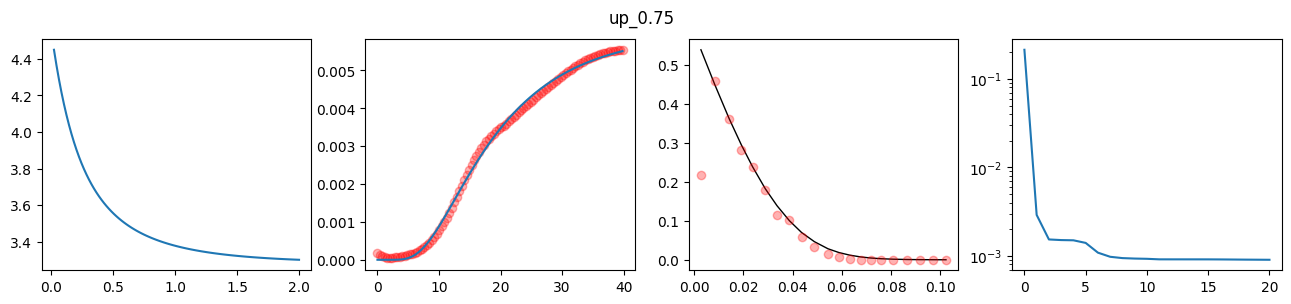

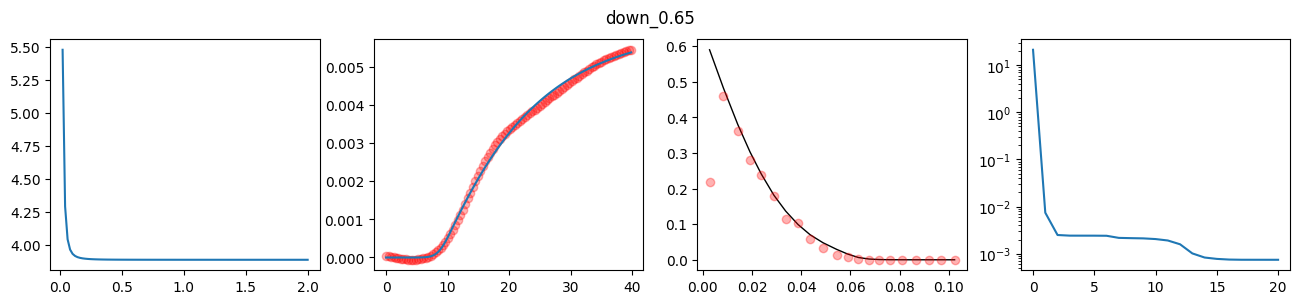

[Errno 2] No such file or directory: '../data_out/finn/p3inn_core2_new_multiprocessing/up_0.95/finn_loss.txt.npy'


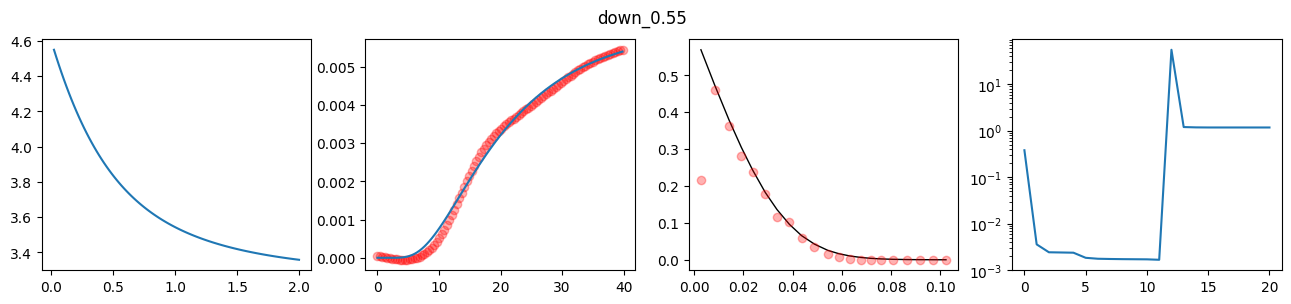

In [28]:
for finn_dir in finn_dirs:
    try:
        u_ret = np.load(finn_dir.u_ret_path)
        loss = np.load(finn_dir.loss_path)
        best_epoch = finn_dir.best_epoch
        ret = np.load(finn_dir.get_pred_ret_path(best_epoch))
        pred_data = np.load(finn_dir.get_data_pred_path(best_epoch))
        data = np.load(finn_dir.c_train_path)
    except FileNotFoundError as e:
        print(e)
        continue

    try:
        core2b_c = compute_core2B_profile(finn_dir)
    except AssertionError:
        print("Skipping due to dt = 0", finn_dir)
        continue

    fig, axs = plt.subplots(ncols=4, figsize=(16, 3))
    fig.suptitle(f"{finn_dir.path.name}")

    axs[0].plot(u_ret[1:], ret[1:])

    axs[1].scatter(t_eval, data, **data_kwargs)
    axs[1].plot(t_eval, pred_data, "-")

    axs[2].plot(data_core2b_df["x"], core2b_c, "-", **pred_kwargs)
    axs[2].scatter(data_core2b_df["x"], data_core2b_df["c_tot"], **data_kwargs)

    axs[3].semilogy(loss, "-")

    plt.show()